# Project: Wrangle and Analyze WeRateDogs Data


## Table Of Content

- [Introduction](#intro)
- [Gathering Data](#gather)
 - [Gathering Data WeRateDogs twitter archive by reading a csv file](#gather_csv)
 - [Gathering image data by downloading a file using the Request library](#gather_request)
 - [Gathering JSON data using a twitter API called Tweepy library](#gather_API)
 - [References Gathering Data](#gather_references)
- [Assessing Data](#assess)
 - [Identifying of quality and tidiness issues](#assess_identify)
 - [Summarizing quality issues](#assess_summary_quality)
 - [Summarizing tidiness issues](assess_summary_tidiness)
 - [References Assessing Data](#assess_references)
- [Cleaning Data](#clean)
 - [Cleaning quality issues](#clean_quality)
 - [Cleaning tidiness issues](#clean_tidiness)
 - [References Cleaning Data](#clean_references)
- [Storing Data](#storing_data)
- [Analyzing and Visualizing Data](#analyzing_data)
 - [Analyzing dog stages](#analyzing_dog_stages)
 - [Analyzing dog breed](#analyzing_dog_breed)
 - [Analysis of number of retweets and favourite counts](#analyzing_retweet_fav_count)
 - [Rating Numerator](#analyzing_rating)
 - [References Data Analysis](#analyzing_ref)


<a id='intro'></a>
## Introduction

In [1]:
# import necessary packages

# import pandas
import pandas as pd
# import numpy
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn
import seaborn as sns
# import package for handling HTTP downloads
import requests
# import package for file handling
import os
# import package for getting data from twitter
import tweepy
from tweepy import OAuthHandler
# import package for handling json data
import json
# import package for handling timers
from timeit import default_timer as timer

<a id='gather'></a>
## Gathering Data
The gathering Data section consists of three parts. 
In the first part I will load the WeRateDogs archive by reading a manually downloaded csv file. 
The second part is about downloading the corresponding image data from a Udacity server. 
The last part of this section deals with API handling and I need to download the JSON data of the tweeds within the WeRateDogs archive. 


<a id='gather_csv'></a>
### Gathering Data WeRateDogs twitter archive by reading a csv file
The data I need to gather is the twitter_archive_enhanced.csv which was manually downloaded before and saved in the same folder as the Jupyter notebook. 

In [2]:
# read csv file
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
# test data frame using head()
df_twitter_archive.head(1)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None


<a id='gather_request'></a>
### Gathering image data by downloading a file using the Request library
This part is about downloading the corresponding image data from a Udacity server. <br>
To download the file programmatically the Request library is used for the following URL: <br>
https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv


In [3]:
# add URL of tsv file
url_image_data = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
# downlad file using request library
response = requests.get(url_image_data)
# write content to a local file with the same name
open('image-predictions.tsv', 'wb').write(response.content)

# check within the folder if the file exists
dir_path = os.path.dirname(os.path.realpath('wrangle_act.ipynb'))
os.listdir(dir_path)

['WeRateDogs_Data.csv',
 'tweet-json.txt',
 'wrangle_act.ipynb',
 '.ipynb_checkpoints',
 'twitter-archive-enhanced.csv',
 'image-predictions.tsv',
 'wrangle_report.html',
 'act_report.ipynb',
 'wrangle_report.ipynb',
 'tweet_json.txt']

In [4]:
# read tsv file and load content into data frame: "df_image_pred"
df_image_pred = pd.read_csv('image-predictions.tsv', sep='\t', header=0)
# test data frame using head()
df_image_pred.head(1)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True


<a id='gather_API'></a>
### Gathering JSON data using a twitter API called Tweepy library
The last part of this section deals with API handling and I need to download the JSON data of the tweeds within the WeRateDogs archive. Python´s Tweepy library will be used to download and store the the entire set of JSON data in a file named: tweet_json.txt . <br>
The JSON data of each file shall be written to its own line and the content of the file will be loaded in to a data frame with (at minimum) tweet ID, retweet count, and favorite count.


#### Prepare settings for Tweepy library

In [5]:
# Query Twitter API for each tweet in the Twitter archive and save JSON in a text file
# These are hidden to comply with Twitter's API terms and conditions
consumer_key = '01cnOAsV4BfkSPfD5J1oznG7q'
consumer_secret = 'OaOGDMt4TqYurq3V4X7hStPNhEeHv0j3mMDQ1Kkm82sEylVDsj'
access_token = '1255078880676847616-7gJfdpXSlIDEt82hXII8jZClQQCh0c'
access_secret = 'iBLa7RaT0kbzPdcj37uTUUBsj1J2VLyI4VEjGxS27IXRg'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True)


In [6]:
# Tweet IDs for which to gather additional data via Twitter's API
tweet_ids = df_twitter_archive.tweet_id.values
len(tweet_ids)

2356

#### Download JSON data from twitter 

In [7]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
    # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
    for tweet_id in tweet_ids:
        count += 1
        print(str(count) + ": " + str(tweet_id))
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print("Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print("Fail")
            fails_dict[tweet_id] = e
            pass
end = timer()

1: 892420643555336193
Success
2: 892177421306343426
Success
3: 891815181378084864
Success
4: 891689557279858688
Success
5: 891327558926688256
Success
6: 891087950875897856
Success
7: 890971913173991426
Success
8: 890729181411237888
Success
9: 890609185150312448
Success
10: 890240255349198849
Success
11: 890006608113172480
Success
12: 889880896479866881
Success
13: 889665388333682689
Success
14: 889638837579907072
Success
15: 889531135344209921
Success
16: 889278841981685760
Success
17: 888917238123831296
Success
18: 888804989199671297
Success
19: 888554962724278272
Success
20: 888202515573088257
Fail
21: 888078434458587136
Success
22: 887705289381826560
Success
23: 887517139158093824
Success
24: 887473957103951883
Success
25: 887343217045368832
Success
26: 887101392804085760
Success
27: 886983233522544640
Success
28: 886736880519319552
Success
29: 886680336477933568
Success
30: 886366144734445568
Success
31: 886267009285017600
Success
32: 886258384151887873
Success
33: 8860541600590725

Fail
262: 842846295480000512
Success
263: 842765311967449089
Success
264: 842535590457499648
Success
265: 842163532590374912
Success
266: 842115215311396866
Success
267: 841833993020538882
Success
268: 841680585030541313
Success
269: 841439858740625411
Success
270: 841320156043304961
Success
271: 841314665196081154
Success
272: 841077006473256960
Success
273: 840761248237133825
Success
274: 840728873075638272
Success
275: 840698636975636481
Success
276: 840696689258311684
Success
277: 840632337062862849
Success
278: 840370681858686976
Success
279: 840268004936019968
Success
280: 839990271299457024
Success
281: 839549326359670784
Success
282: 839290600511926273
Success
283: 839239871831150596
Success
284: 838952994649550848
Success
285: 838921590096166913
Success
286: 838916489579200512
Success
287: 838831947270979586
Success
288: 838561493054533637
Success
289: 838476387338051585
Success
290: 838201503651401729
Success
291: 838150277551247360
Success
292: 838085839343206401
Success
293

Success
519: 810657578271330305
Success
520: 810284430598270976
Success
521: 810254108431155201
Success
522: 809920764300447744
Success
523: 809808892968534016
Success
524: 809448704142938112
Success
525: 809220051211603969
Success
526: 809084759137812480
Success
527: 808838249661788160
Success
528: 808733504066486276
Success
529: 808501579447930884
Success
530: 808344865868283904
Success
531: 808134635716833280
Success
532: 808106460588765185
Success
533: 808001312164028416
Success
534: 807621403335917568
Success
535: 807106840509214720
Success
536: 807059379405148160
Success
537: 807010152071229440
Success
538: 806629075125202948
Success
539: 806620845233815552
Success
540: 806576416489959424
Success
541: 806542213899489280
Success
542: 806242860592926720
Success
543: 806219024703037440
Success
544: 805958939288408065
Success
545: 805932879469572096
Success
546: 805826884734976000
Success
547: 805823200554876929
Success
548: 805520635690676224
Success
549: 805487436403003392
Success


Success
776: 776201521193218049
Success
777: 776113305656188928
Success
778: 776088319444877312
Success
779: 775898661951791106
Success
780: 775842724423557120
Success
781: 775733305207554048
Success
782: 775729183532220416
Success
783: 775364825476165632
Success
784: 775350846108426240
Success
785: 775096608509886464
Fail
786: 775085132600442880
Success
787: 774757898236878852
Success
788: 774639387460112384
Success
789: 774314403806253056
Success
790: 773985732834758656
Success
791: 773922284943896577
Success
792: 773704687002451968
Success
793: 773670353721753600
Success
794: 773547596996571136
Success
795: 773336787167145985
Success
796: 773308824254029826
Success
797: 773247561583001600
Success
798: 773191612633579521
Success
799: 772877495989305348
Success
800: 772826264096874500
Success
801: 772615324260794368
Success
802: 772581559778025472
Success
803: 772193107915964416
Success
804: 772152991789019136
Success
805: 772117678702071809
Success
806: 772114945936949249
Success
807

Success
1032: 745422732645535745
Success
1033: 745314880350101504
Success
1034: 745074613265149952
Success
1035: 745057283344719872
Success
1036: 744995568523612160
Success
1037: 744971049620602880
Success
1038: 744709971296780288
Success
1039: 744334592493166593
Success
1040: 744234799360020481
Success
1041: 744223424764059648
Success
1042: 743980027717509120
Success
1043: 743895849529389061
Success
1044: 743835915802583040
Success
1045: 743609206067040256
Success
1046: 743595368194129920
Success
1047: 743545585370791937
Success
1048: 743510151680958465
Success
1049: 743253157753532416
Success
1050: 743222593470234624
Success
1051: 743210557239623680
Success
1052: 742534281772302336
Success
1053: 742528092657332225
Success
1054: 742465774154047488
Success
1055: 742423170473463808
Success
1056: 742385895052087300
Success
1057: 742161199639494656
Success
1058: 742150209887731712
Success
1059: 741793263812808706
Success
1060: 741743634094141440
Success
1061: 741438259667034112
Success
10

Success
1282: 708810915978854401
Success
1283: 708738143638450176
Success
1284: 708711088997666817
Success
1285: 708479650088034305
Success
1286: 708469915515297792
Success
1287: 708400866336894977
Success
1288: 708356463048204288
Success
1289: 708349470027751425
Success
1290: 708149363256774660
Success
1291: 708130923141795840
Success
1292: 708119489313951744
Success
1293: 708109389455101952
Success
1294: 708026248782585858
Success
1295: 707995814724026368
Success
1296: 707983188426153984
Success
1297: 707969809498152960
Success
1298: 707776935007539200
Success
1299: 707741517457260545
Success
1300: 707738799544082433
Success
1301: 707693576495472641
Success
1302: 707629649552134146
Success
1303: 707610948723478529
Success
1304: 707420581654872064
Success
1305: 707411934438625280
Success
1306: 707387676719185920
Success
1307: 707377100785885184
Success
1308: 707315916783140866
Success
1309: 707297311098011648
Success
1310: 707059547140169728
Success
1311: 707038192327901184
Success
13

Success
1531: 690021994562220032
Success
1532: 690015576308211712
Success
1533: 690005060500217858
Success
1534: 689999384604450816
Success
1535: 689993469801164801
Success
1536: 689977555533848577
Success
1537: 689905486972461056
Success
1538: 689877686181715968
Success
1539: 689835978131935233
Success
1540: 689661964914655233
Success
1541: 689659372465688576
Success
1542: 689623661272240129
Success
1543: 689599056876867584
Success
1544: 689557536375177216
Success
1545: 689517482558820352
Success
1546: 689289219123089408
Success
1547: 689283819090870273
Success
1548: 689280876073582592
Success
1549: 689275259254616065
Success
1550: 689255633275777024
Success
1551: 689154315265683456
Success
1552: 689143371370250240
Success
1553: 688916208532455424
Success
1554: 688908934925697024
Success
1555: 688898160958271489
Success
1556: 688894073864884227
Success
1557: 688828561667567616
Success
1558: 688804835492233216
Success
1559: 688789766343622656
Success
1560: 688547210804498433
Success
15

Success
1780: 677716515794329600
Success
1781: 677700003327029250
Success
1782: 677698403548192770
Success
1783: 677687604918272002
Success
1784: 677673981332312066
Success
1785: 677662372920729601
Success
1786: 677644091929329666
Success
1787: 677573743309385728
Success
1788: 677565715327688705
Success
1789: 677557565589463040
Success
1790: 677547928504967168
Success
1791: 677530072887205888
Success
1792: 677335745548390400
Success
1793: 677334615166730240
Success
1794: 677331501395156992
Success
1795: 677328882937298944
Success
1796: 677314812125323265
Success
1797: 677301033169788928
Success
1798: 677269281705472000
Success
1799: 677228873407442944
Success
1800: 677187300187611136
Success
1801: 676975532580409345
Success
1802: 676957860086095872
Success
1803: 676949632774234114
Success
1804: 676948236477857792
Success
1805: 676946864479084545
Success
1806: 676942428000112642
Success
1807: 676936541936185344
Success
1808: 676916996760600576
Success
1809: 676897532954456065
Success
18

Success
2029: 671866342182637568
Success
2030: 671855973984772097
Success
2031: 671789708968640512
Success
2032: 671768281401958400
Success
2033: 671763349865160704
Success
2034: 671744970634719232
Success
2035: 671743150407421952
Success
2036: 671735591348891648
Success
2037: 671729906628341761
Success
2038: 671561002136281088
Success
2039: 671550332464455680
Success
2040: 671547767500775424
Success
2041: 671544874165002241
Success
2042: 671542985629241344
Success
2043: 671538301157904385
Success
2044: 671536543010570240
Success
2045: 671533943490011136
Success
2046: 671528761649688577
Success
2047: 671520732782923777
Success
2048: 671518598289059840
Success
2049: 671511350426865664
Success
2050: 671504605491109889
Success
2051: 671497587707535361
Success
2052: 671488513339211776
Success
2053: 671486386088865792
Success
2054: 671485057807351808
Success
2055: 671390180817915904
Success
2056: 671362598324076544
Success
2057: 671357843010908160
Success
2058: 671355857343524864
Success
20

Success
2278: 667437278097252352
Success
2279: 667435689202614272
Success
2280: 667405339315146752
Success
2281: 667393430834667520
Success
2282: 667369227918143488
Success
2283: 667211855547486208
Success
2284: 667200525029539841
Success
2285: 667192066997374976
Success
2286: 667188689915760640
Success
2287: 667182792070062081
Success
2288: 667177989038297088
Success
2289: 667176164155375616
Success
2290: 667174963120574464
Success
2291: 667171260800061440
Success
2292: 667165590075940865
Success
2293: 667160273090932737
Success
2294: 667152164079423490
Success
2295: 667138269671505920
Success
2296: 667119796878725120
Success
2297: 667090893657276420
Success
2298: 667073648344346624
Success
2299: 667070482143944705
Success
2300: 667065535570550784
Success
2301: 667062181243039745
Success
2302: 667044094246576128
Success
2303: 667012601033924608
Success
2304: 666996132027977728
Success
2305: 666983947667116034
Success
2306: 666837028449972224
Success
2307: 666835007768551424
Success
23

In [8]:
print('Time for downloading data: {} s'.format(end - start))
print('Number of failed entries: {}'.format(len(fails_dict)))
print('Download failed entries:')
print(fails_dict)

Time for downloading data: 1912.7835126319997 s
Number of failed entries: 25
Download failed entries:
{888202515573088257: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 873697596434513921: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 872668790621863937: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 872261713294495745: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 869988702071779329: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 866816280283807744: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 861769973181624320: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 856602993587888130: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 851953902622658560: TweepError([{'code': 144, 'message': 'No status found with that ID.'}],), 845459076796616705: TweepError([{'code': 144, 'mess

#### Read JSON file

In [9]:
# read downloaded json file containing extra data from twitter and store them in data frame
# minimum: tweet ID, retweet count, and favorite count

# parse JSON data into data frame
df_twitter_add_data = pd.DataFrame(columns=['tweet_id', 'retweet_count', 'favorite_count'])
with open('tweet_json.txt') as f:
    for line in f:
        status  = json.loads(line)
        tweet_id = status['id_str']
        retweet_count = status['retweet_count']
        favorite_count = status['favorite_count']
        df_twitter_add_data = df_twitter_add_data.append(pd.DataFrame([[tweet_id, retweet_count, favorite_count]],
                                        columns=['tweet_id', 'retweet_count', 'favorite_count']))

# reset index of data frame
df_twitter_add_data = df_twitter_add_data.reset_index(drop=True)
# test data frame
df_twitter_add_data.head(1)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,7728,36322


<a id='gather_references'></a>
### References Gathering Data
Find files in folder: https://stackoverflow.com/questions/5137497/find-current-directory-and-files-directory <br>
Access Twitter API: Udacity Data Analyst Nanodegree, Part 4, Project Wrangle and Analyze Data, Lesson 4. Twitter API <br>
Reading and Writing JSON to a File in Python : https://stackabuse.com/reading-and-writing-json-to-a-file-in-python/ <br>
JSONDecodeError when reading "tweet_json.txt" file : https://knowledge.udacity.com/questions/28389 <br>

<a id='assess'></a>
## Assessing Data
In this section I will assess the data to identify quality and tidiness issues. <br>
The first part is about checking the data visually and programmatically. <br>
All found issues will be collected and describes in the second and third part. 

<a id='assess_identify'></a>
### Identifying quality and tidiness issues

#### Table df_twitter_archive

In [10]:
# overview of data columns, data types and missing values
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

##### Notes

**quality**<br>
181 entries are retwitted data which are relevant for original tweets <br>
78 entries are in_reply data which are relevant for original tweets <br>
tweet_id should be a string, not an int <br>
timestamp should be datetime, not a string <br>


**tidiness**<br>
4 different columns for dog stages, 1 should be enough <br>
retweeted columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp)can be deleted, because they are not relevant for original tweets <br>
reply columns (in_reply_to_status_id, in_reply_to_user_id) can be deleted, because they are not relevant for original tweets <br>

In [11]:
# load 5 random samples of data frame get a first overview
df_twitter_archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
196,854732716440526848,NaN,NaN,2017-04-19 16:25:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Marlee. She fetched a flower and immed...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/854732716...,12,10,Marlee,None,None,None,None
426,821407182352777218,NaN,NaN,2017-01-17 17:21:47 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Sundance. He's a doggo drummer. Even s...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/821407182...,14,10,Sundance,doggo,None,None,None
1966,673343217010679808,NaN,NaN,2015-12-06 03:28:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",IT'S SO SMALL ERMERGERF 11/10 https://t.co/dNU...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/673343217...,11,10,None,None,None,None,None
1042,743895849529389061,NaN,NaN,2016-06-17 19:59:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you're given AUX cord privileges from the...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/743895849...,10,10,None,None,None,None,None
1371,702276748847800320,NaN,NaN,2016-02-23 23:39:59 +0000,"<a href=""http://twitter.com/download/iphone"" r...","""AND IIIIIIIIIIIEIIIIIIIIIIIII WILL ALWAYS LOV...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/702276748...,11,10,None,None,None,None,None


In [12]:
sum(df_twitter_archive.duplicated())

0

In [13]:
df_twitter_archive.name.unique().shape[0]

957

In [14]:
df_twitter_archive.name.value_counts()

None          745
a              55
Charlie        12
Lucy           11
Cooper         11
Oliver         11
Lola           10
Penny          10
Tucker         10
Bo              9
Winston         9
Sadie           8
the             8
Buddy           7
Daisy           7
an              7
Bailey          7
Toby            7
Bella           6
Dave            6
Stanley         6
Koda            6
Leo             6
Scout           6
Jack            6
Oscar           6
Rusty           6
Jax             6
Milo            6
Alfie           5
             ... 
Carper          1
Tobi            1
Tuck            1
Stuart          1
Rumpole         1
Mojo            1
Severus         1
Brandonald      1
Taco            1
Creg            1
Mookie          1
Arya            1
Naphaniel       1
Kaiya           1
Poppy           1
Darla           1
Strider         1
Jersey          1
Joshwa          1
Jo              1
Ralph           1
Tug             1
Ginger          1
Billl           1
Karll     

In [15]:
# calculate the percentage of dogs having no stage (All 4 stage are "None")
df_temp = df_twitter_archive.query('doggo == "None" & floofer == "None" & pupper == "None" & puppo == "None"');
df_temp.shape[0] / df_twitter_archive.shape[0]

0.8387096774193549

##### Notes

**quality**<br>
Incorrect dog name -> There are 745 entries without a name, 55 with the name "a", 8 with the name "the", 7 with the name "an" and 1 with the name "my" <br>
Nearly 84% of the dogs have no stage (all 4 stages are "None") <br>

**tidiness**<br>
n.a.

In [16]:
# overview of statistics of numeric values
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


##### Notes
n.a.

#### Table df_image_pred

In [17]:
# overview of data columns, data types and missing values
df_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


##### Notes

**quality**<br>
tweet_id should be a string, not an int <br>
columns should be renamed for an easier understanding of the content <br>

**tidiness**<br>
n.a.

In [18]:
# load 5 random sample of data frame get a first overview
df_image_pred.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
287,671154572044468225,https://pbs.twimg.com/media/CVBrhXoWIAAox_C.jpg,1,Labrador_retriever,0.495047,True,Chesapeake_Bay_retriever,0.350188,True,golden_retriever,0.142400,True
1775,828372645993398273,https://pbs.twimg.com/media/C374hb0WQAAIbQ-.jpg,1,malamute,0.663047,True,Eskimo_dog,0.207779,True,Tibetan_mastiff,0.040949,True
369,672970152493887488,https://pbs.twimg.com/media/CVbeyGUU8AEq300.jpg,1,leaf_beetle,0.340154,False,rhinoceros_beetle,0.139698,False,crayfish,0.058034,False
1951,863432100342583297,https://pbs.twimg.com/media/C_uG6eAUAAAvMvR.jpg,1,Staffordshire_bullterrier,0.690517,True,French_bulldog,0.103360,True,beagle,0.079489,True
2014,879415818425184262,https://pbs.twimg.com/ext_tw_video_thumb/87941...,1,English_springer,0.383404,True,Boston_bull,0.134967,True,Cardigan,0.110481,True


In [19]:
# check entries with NO prediction for a dog for all three predictions
df_no_dog_pred = df_image_pred.query('p1_dog == False & p2_dog == False & p3_dog == False');
df_no_dog_pred.count()

tweet_id    324
jpg_url     324
img_num     324
p1          324
p1_conf     324
p1_dog      324
p2          324
p2_conf     324
p2_dog      324
p3          324
p3_conf     324
p3_dog      324
dtype: int64

In [20]:
# overview of statistics of numeric values
df_image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


##### Notes

**quality**<br>
324 entries predict no dog for all three predictions. <br>

**tidiness**<br>
n.a.

#### Table df_twitter_add_data

In [21]:
# overview of data columns, data types and missing values
df_twitter_add_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null object
favorite_count    2331 non-null object
dtypes: object(3)
memory usage: 54.7+ KB


In [22]:
# load 5 random sample of data frame get a first overview
df_twitter_add_data.sample(5)

,tweet_id,retweet_count,favorite_count
1125,726828223124897792,1001,3555
2208,668204964695683073,187,539
1514,689835978131935233,743,2172
927,751950017322246144,931,3090
983,747600769478692864,555,2343


##### Notes

**quality**<br>
retweet_count should be an int, not a string <br>
favorite_count should be an int, not a string <br>

**tidiness**<br>
n.a.

In [23]:
# no numeric values in dataframe df_twitter_add_data so far

<a id='assess_summary_quality'></a>
### Summarizing quality issues

**df_twitter_archive table** <br>
Q1) 181 retwitted data should be deleted, because they are not relevant for original tweets <br>
Q2) 78 in_reply data should be deleted, because they are not relevant for original tweets <br>
Q3) tweet_id should be a string, not an int <br>
Q4) timestamp should be datetime, not a string <br>
Q5) missing or incorrect dog name -> 'None', 'a', 'an, 'the', 'my' <br>
Q6) Nearly 84% of the dogs have no stage (all 4 stages are "None") : <br>_Will not be cleaned, because it would remove ~ 84% of the rows_ <br>

**df_image_pred table** <br>
Q7) tweet_id should be a string, not an int <br>
Q8) columns should be renamed for an easier understanding of the content <br>
Q9) 324 entries predict no dog for all three predictions. <br>


**df_twitter_add_data table** <br>
Q10) retweet_count should be an int, not a string <br>
Q11) favorite_count should be an int, not a string <br>


<a id='assess_summary_tidiness'></a>
### Summarizing tidiness issues

**df_twitter_archive table** <br>
T1) dog stages should be merged to one column -> categorical variable<br>
T2) retweeted columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) can be deleted, because they are not relevant for original tweets <br>
T3) reply columns (in_reply_to_status_id, in_reply_to_user_id) can be deleted, because they are not relevant for original tweets <br>

**df_image_pred table** <br>
n.a. <br>

**df_twitter_add_data table** <br>
n.a. <br>

**general**<br>
T4) all 3 data frames should be merged into one <br>

<a id='assess_references'></a>
### References Assessing Data
n.a.

<a id='clean'></a>
## Cleaning Data
Within this section every of the previously mentioned issued will be cleaned.

In [24]:
# creating copies of all three data frames
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_pred_clean = df_image_pred.copy()
df_twitter_add_data_clean = df_twitter_add_data.copy()

<a id='clean_quality'></a>
### Clean Quality Issues

### Q1) df_twitter_archive_clean table: 181 retwitted data should be deleted, because they are not relevant for original tweets 

#### Define
Delete all 181 rows with a value in the column retweeted_status_id, because these rows correspond to retweet which are not original tweets on which we want to focus. <br>

#### Code

In [25]:
# drop rows which contain values in column retweeted_status_id -> keep rows with NaN values in this column
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean['retweeted_status_id'])];


#### Test

In [26]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2175 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2175 non-null object
source                        2175 non-null object
text                          2175 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2117 non-null object
rating_numerator              2175 non-null int64
rating_denominator            2175 non-null int64
name                          2175 non-null object
doggo                         2175 non-null object
floofer                       2175 non-null object
pupper                        2175 non-null object
puppo                         2175 non-null object
dtypes: float64(4), int64(3), object(1

### Q2) df_twitter_archive_clean table: 78 in_reply data should be deleted, because they are not relevant for original tweets

#### Define
Delete all 78 rows with a value in the column in_reply_to_status_id, because these rows correspond to replies which are not original tweets on which we want to focus. <br>

#### Code

In [27]:
# drop rows which contain values in column in_reply_to_status_id -> keep rows with NaN values in this column
df_twitter_archive_clean = df_twitter_archive_clean[pd.isnull(df_twitter_archive_clean['in_reply_to_status_id'])]


#### Test

In [28]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(3), object(10)

### Q3) df_twitter_archive_clean table: tweet_id should be a string, not an int

#### Define
Change data type of column tweet_id to string

#### Code

In [29]:
# change data type to str
df_twitter_archive_clean = df_twitter_archive_clean.astype({'tweet_id': str}) 

#### Test

In [30]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null object
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: float64(4), int64(2), object(11

### Q4) df_twitter_archive_clean table: timestamp should be datetime, not a string

#### Define
Change data type of column timestamp to datetime

#### Code

In [31]:
# change data type to datetime
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp']);


#### Test

In [32]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2097 non-null object
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2097 non-null datetime64[ns]
source                        2097 non-null object
text                          2097 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2094 non-null object
rating_numerator              2097 non-null int64
rating_denominator            2097 non-null int64
name                          2097 non-null object
doggo                         2097 non-null object
floofer                       2097 non-null object
pupper                        2097 non-null object
puppo                         2097 non-null object
dtypes: datetime64[ns](1), floa

### Q5) df_twitter_archive_clean table: missing or incorrect dog name -> 'None', 'a', 'an, 'the', 'my'

#### Define
Delete all entries (rows) with a strange dog name (name is on of the follwoing entries: 'None', 'a', 'an, 'the', 'my')

#### Code

In [33]:
# identify indices of rows with dog name "None", "a", "an, "the", "my"
indices_strange_dog_name = df_twitter_archive_clean.query('name == "None" or name == "a" or name == "an" or name == "the" or name == "my"').index

# drop rows with strange dog names
df_twitter_archive_clean.drop(indices_strange_dog_name, axis=0, inplace=True)


#### Test

In [34]:
# identify indices of rows with dog name "None", "a", "an, "the", "my"
indices_strange_dog_name = df_twitter_archive_clean.query('name == "None" or name == "a" or name == "an" or name == "the" or name == "my"').index

# get size
indices_strange_dog_name.shape[0]

0

### Q6) df_twitter_archive_clean table: some dogs have no stage (all 4 stages are "None")

_Will not be cleaned, because it would remove ~ 84% of the rows and it is not in the focus of the data analysis_ <br>

### Q7) df_image_pred_clean table: tweet_id should be a string, not an int

#### Define
Change data type of column tweet_id to string

#### Code

In [35]:
# change data type to int
df_image_pred_clean = df_image_pred_clean.astype({'tweet_id': str}) 

#### Test

In [36]:
df_image_pred_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Q8) df_image_pred_clean table: columns should be renamed for an easier understanding of the content 

#### Define
Rename column header into: ['tweet_id', 'image_url', 'number_of_images', 'pred1_dog_breed', 'pred1_confidence', 'pred1_is_dog', 'pred2_dog_breed', 'pred2_confidence', 'pred2_is_dog', 'pred3_dog_breed', 'pred3_confidence', 'pred3_is_dog']

#### Code

In [37]:
# change column naming for easier understanding of the content
df_image_pred_clean.columns = ['tweet_id', 'image_url', 'number_of_images', 'pred1_dog_breed', 'pred1_confidence', 'pred1_is_dog', 'pred2_dog_breed', 'pred2_confidence', 'pred2_is_dog', 'pred3_dog_breed', 'pred3_confidence', 'pred3_is_dog']


#### Test

In [38]:
df_image_pred_clean

,tweet_id,image_url,number_of_images,pred1_dog_breed,pred1_confidence,pred1_is_dog,pred2_dog_breed,pred2_confidence,pred2_is_dog,pred3_dog_breed,pred3_confidence,pred3_is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


### Q9) df_image_pred_clean table: 324 entries predict no dog for all three predictions.

#### Define
Delete all 324 entries without any dog prediction

#### Code

In [39]:
df_image_pred_clean

,tweet_id,image_url,number_of_images,pred1_dog_breed,pred1_confidence,pred1_is_dog,pred2_dog_breed,pred2_confidence,pred2_is_dog,pred3_dog_breed,pred3_confidence,pred3_is_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


In [40]:
# drop rows which contain no dogs (p1_dog, p2_dog and p3_dog are all False)
indices_to_delete = df_image_pred_clean.query('pred1_is_dog == False & pred2_is_dog == False & pred3_is_dog == False').index
df_image_pred_clean.drop(indices_to_delete, axis=0, inplace=True);


#### Test

In [41]:
df_image_pred_clean.query('pred1_is_dog == False & pred2_is_dog == False & pred3_is_dog == False').shape[0]

0

### Q10) df_twitter_add_data_clean table: retweet_count should be an int, not a string

#### Define
Change data type of column retweet_count to int

#### Code

In [42]:
# change data type to int
df_twitter_add_data_clean = df_twitter_add_data_clean.astype({'retweet_count': int}) 


#### Test

In [43]:
df_twitter_add_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null object
dtypes: int64(1), object(2)
memory usage: 54.7+ KB


### Q11) df_twitter_add_data_clean table: favorite_count should be an int, not a string

#### Define
Change data type of column favorite_count to int

#### Code

In [44]:
# change data type to int
df_twitter_add_data_clean = df_twitter_add_data_clean.astype({'favorite_count': int}) 


#### Test

In [45]:
df_twitter_add_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
tweet_id          2331 non-null object
retweet_count     2331 non-null int64
favorite_count    2331 non-null int64
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


<a id='clean_tidiness'></a>
### Clean Tidiness Issues

### T1) df_twitter_archive table: dog stages should be merged to one column

#### Define
(  i) Create new column called dog_stage. <br>
( ii) copy content of the 4 idividual stages into column dog_stage <br>
(iii) drop columns of the 4 individual stages <br>

#### Code

In [46]:
# create column stage with default value "None"
df_twitter_archive_clean['dog_stage'] = "None"

df_twitter_archive_clean.reset_index(drop=True, inplace=True)


In [47]:
# get index of column dog_stage
index_dog_stage = df_twitter_archive_clean.shape[1]-1;
# get indices of rows with stages
indices_doggo = df_twitter_archive_clean.query('doggo != "None"').index 
indices_floofer = df_twitter_archive_clean.query('floofer != "None"').index
indices_pupper = df_twitter_archive_clean.query('pupper != "None"').index
indices_puppo = df_twitter_archive_clean.query('puppo != "None"').index
#indices_floofer


In [48]:
# set values of dog_stages
df_twitter_archive_clean.iloc[indices_doggo, index_dog_stage] = "doggo"
df_twitter_archive_clean.iloc[indices_floofer, index_dog_stage] = "floofer"
df_twitter_archive_clean.iloc[indices_pupper, index_dog_stage] = "pupper"
df_twitter_archive_clean.iloc[indices_puppo, index_dog_stage] = "puppo"


In [49]:
# drop columns doggo, 
df_twitter_archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1, inplace=True);


#### Test

In [50]:
df_twitter_archive_clean.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,dog_stage
902,697259378236399616,NaN,NaN,2016-02-10 03:22:44,"<a href=""http://twitter.com/download/iphone"" r...",Please stop sending in saber-toothed tigers. T...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/697259378...,8,10,getting,None
88,866334964761202691,NaN,NaN,2017-05-21 16:48:45,"<a href=""http://twitter.com/download/iphone"" r...",This is Coco. At first I thought she was a clo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None
1400,667211855547486208,NaN,NaN,2015-11-19 05:24:37,"<a href=""http://twitter.com/download/iphone"" r...",This is Genevieve. She is a golden retriever c...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/667211855...,9,10,Genevieve,None
1018,684460069371654144,NaN,NaN,2016-01-05 19:42:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Jeph. He's a Western Sagittarius Dookm...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/684460069...,10,10,Jeph,None
37,882268110199369728,NaN,NaN,2017-07-04 16:01:23,"<a href=""http://twitter.com/download/iphone"" r...",This is Alfy. You're witnessing his first wate...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882268110...,13,10,Alfy,None


### T2) df_twitter_archive table: retweeted columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) can be deleted, because they are not relevant for original tweets

#### Define
Delete retweet related columns (retweeted_status_id, retweeted_status_user_id, retweeted_status_timestamp) <br>

#### Code

In [51]:
# drop retweet related columns
df_twitter_archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True);


#### Test

In [52]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 11 columns):
tweet_id                 1424 non-null object
in_reply_to_status_id    0 non-null float64
in_reply_to_user_id      0 non-null float64
timestamp                1424 non-null datetime64[ns]
source                   1424 non-null object
text                     1424 non-null object
expanded_urls            1424 non-null object
rating_numerator         1424 non-null int64
rating_denominator       1424 non-null int64
name                     1424 non-null object
dog_stage                1424 non-null object
dtypes: datetime64[ns](1), float64(2), int64(2), object(6)
memory usage: 122.5+ KB


### T3) df_twitter_archive table: reply columns (in_reply_to_status_id, in_reply_to_user_id) can be deleted, because they are not relevant for original tweets

#### Define
Ddelete reply related columns (in_reply_to_status_id, in_reply_to_user_id) <br>

#### Code

In [53]:
# drop reply related columns
df_twitter_archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id'], axis=1, inplace=True)


#### Test

In [54]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1424 entries, 0 to 1423
Data columns (total 9 columns):
tweet_id              1424 non-null object
timestamp             1424 non-null datetime64[ns]
source                1424 non-null object
text                  1424 non-null object
expanded_urls         1424 non-null object
rating_numerator      1424 non-null int64
rating_denominator    1424 non-null int64
name                  1424 non-null object
dog_stage             1424 non-null object
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 100.2+ KB


### T4) all 3 data frames should be merged into one

#### Define
merge all 3 tables into a single one <br>

#### Code

In [55]:
# create empty data frame
df_we_rate_dogs=[];

# create a copy of the data frame df_twitter_archive_clean
df_we_rate_dogs = df_twitter_archive_clean.copy()
# merge data frames: df_twitter_archive_clean & df_twitter_add_data_clean into df_we_rate_dogs
df_we_rate_dogs = pd.merge(df_we_rate_dogs, df_twitter_add_data_clean, on=['tweet_id'])
# merge data frames: df_we_rate_dogs & df_image_pred_clean into df_we_rate_dogs
df_we_rate_dogs = pd.merge(df_we_rate_dogs, df_image_pred_clean, on=['tweet_id'])


#### Test

In [56]:
# Test size of the data frame
print('Merged data frame has {} entries'.format(df_we_rate_dogs.shape[0]))
print('Merged data frame has {} columns'.format(df_we_rate_dogs.shape[1]))
# show 5 samples to see all columns
df_we_rate_dogs.sample(5)

Merged data frame has 1201 entries
Merged data frame has 22 columns


,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,number_of_images,pred1_dog_breed,pred1_confidence,pred1_is_dog,pred2_dog_breed,pred2_confidence,pred2_is_dog,pred3_dog_breed,pred3_confidence,pred3_is_dog
409,777885040357281792,2016-09-19 15:00:20,"<a href=""http://twitter.com/download/iphone"" r...",This is Wesley. He's clearly trespassing. Seem...,https://twitter.com/dog_rates/status/777885040...,3,10,Wesley,None,1653,...,1,Afghan_hound,0.123529,True,basset,0.119682,True,Siberian_husky,0.108709,True
869,684241637099323392,2016-01-05 05:14:53,"<a href=""http://twitter.com/download/iphone"" r...",This is Obi. He got camera shy. 12/10 https://...,https://twitter.com/dog_rates/status/684241637...,12,10,Obi,None,3282,...,1,Pembroke,0.508498,True,black-footed_ferret,0.115532,False,weasel,0.051280,False
384,784431430411685888,2016-10-07 16:33:21,"<a href=""http://twitter.com/download/iphone"" r...",This is Stormy. He's curly af. Already pupared...,https://twitter.com/dog_rates/status/784431430...,12,10,Stormy,None,1304,...,1,miniature_poodle,0.744819,True,toy_poodle,0.243192,True,standard_poodle,0.010920,True
240,818614493328580609,2017-01-10 00:24:38,"<a href=""http://twitter.com/download/iphone"" r...",This is Bear. He's a passionate believer of th...,https://twitter.com/dog_rates/status/818614493...,12,10,Bear,None,2617,...,4,Chihuahua,0.450722,True,Border_terrier,0.204177,True,beagle,0.092774,True
1170,667534815156183040,2015-11-20 02:47:56,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","This is Frank (pronounced ""Fronq""). Too many b...",https://twitter.com/dog_rates/status/667534815...,8,10,Frank,None,498,...,1,Pembroke,0.435254,True,Cardigan,0.307407,True,cocker_spaniel,0.033158,True


In [57]:
# compare number of columns of new data frame to sum of number of columns for each data frame
# (-2, because tweet_id is in every data frame -> 3x, but just one time in the new data frame)
df_we_rate_dogs.shape[1] - (df_twitter_archive_clean.shape[1] + df_twitter_add_data_clean.shape[1] + df_image_pred_clean.shape[1] - 2)


0

<a id='clean_references'></a>
### References Cleaning Data
Keeping NaN values and dropping nonmissing values: https://stackoverflow.com/questions/25430995/keeping-nan-values-and-dropping-nonmissing-values <br>


<a id='storing_data'></a>
## Storing Data
Data of the data frame will be stored in a csv file

In [58]:
# save data to csv file
df_we_rate_dogs.to_csv('twitter_archive_master.csv', index=False)

In [59]:
# show all csv files in current folder
! ls *csv

twitter-archive-enhanced.csv  twitter_archive_master.csv  WeRateDogs_Data.csv


<a id='analyzing_data'></a>
## Analyzing and Visualizing Data

In [60]:
# read csv file
df_we_rate_dogs = pd.read_csv('twitter_archive_master.csv')
# show 2 sample data
df_we_rate_dogs.sample(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,dog_stage,retweet_count,...,number_of_images,pred1_dog_breed,pred1_confidence,pred1_is_dog,pred2_dog_breed,pred2_confidence,pred2_is_dog,pred3_dog_breed,pred3_confidence,pred3_is_dog
1042,672245253877968896,2015-12-03 02:45:32,"<a href=""http://twitter.com/download/iphone"" r...",Meet Snickers. He's adorable. Also comes in t-...,https://twitter.com/dog_rates/status/672245253...,12,10,Snickers,None,149,...,1,Chihuahua,0.718944,True,badger,0.178546,False,toy_terrier,0.037103,True
175,832636094638288896,2017-02-17 17:01:29,"<a href=""http://twitter.com/download/iphone"" r...",This is Orion. He just got back from the denti...,https://twitter.com/dog_rates/status/832636094...,12,10,Orion,None,2814,...,1,Eskimo_dog,0.525032,True,Siberian_husky,0.252238,True,malamute,0.216839,True


<a id='analyzing_dog_stages'></a>
### Analyzing dog stages

In [61]:
# dog_stages value counts
df_we_rate_dogs.dog_stage.value_counts()

None       1048
pupper      101
doggo        32
puppo        15
floofer       5
Name: dog_stage, dtype: int64

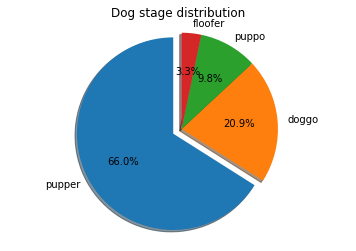

In [62]:
# pie plot dog stages without "None"

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'pupper', 'doggo', 'puppo', 'floofer'
sizes = df_we_rate_dogs.query('dog_stage != "None"').dog_stage.value_counts()
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Dog stage distribution')
plt.show()

Pupper is the most common dog stage. 66% of the dog stages are pupper, followed by doggo with 20%. 

<a id='analyzing_dog_breed'></a>
### Analyzing the most predicted dog breed

In [63]:
# breed predication (taking only the first prediction into account)
df_we_rate_dogs.pred1_dog_breed.value_counts()

golden_retriever             94
Pembroke                     64
Labrador_retriever           64
Chihuahua                    59
pug                          40
chow                         32
toy_poodle                   27
Pomeranian                   26
malamute                     22
Samoyed                      22
French_bulldog               21
cocker_spaniel               19
Siberian_husky               19
Chesapeake_Bay_retriever     17
miniature_pinscher           16
Shih-Tzu                     15
Staffordshire_bullterrier    15
seat_belt                    15
Cardigan                     14
German_shepherd              14
Shetland_sheepdog            14
beagle                       13
Eskimo_dog                   12
Old_English_sheepdog         11
Italian_greyhound            11
Pekinese                     11
Border_collie                10
basset                       10
collie                       10
vizsla                       10
                             ..
tricycle

Based on the image prediction, the most popular dog is the Golden Retriever. 

<a id='analyzing_retweet_fav_count'></a>
### Analysis of number of retweets and favourite counts

In [64]:
# calculate mean and median
df_we_rate_dogs.favorite_count.describe()

count      1201.000000
mean       8936.158201
std       11596.685711
min          98.000000
25%        2233.000000
50%        4840.000000
75%       11442.000000
max      121125.000000
Name: favorite_count, dtype: float64

The mean favourite count is 8937, while its median is 4840.

In [65]:
# calculate mean and median
df_we_rate_dogs.retweet_count.describe()

count     1201.000000
mean      2487.485429
std       3783.111780
min         18.000000
25%        645.000000
50%       1435.000000
75%       2954.000000
max      56986.000000
Name: retweet_count, dtype: float64

The mean retweet count is 2888, while its median is 1435.

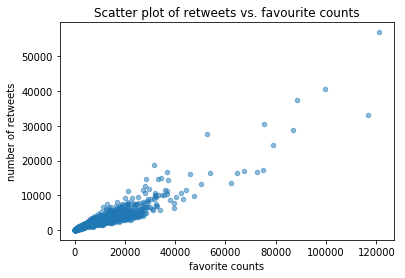

In [66]:
# scatter plot
df_we_rate_dogs.plot(kind='scatter',x='favorite_count',y='retweet_count', alpha = 0.5);
plt.xlabel('favorite counts');
plt.ylabel('number of retweets');
plt.title('Scatter plot of retweets vs. favourite counts');

It looks like there is a correlation between the number of retweets and the favourite counts it gets.

<a id='analyzing_rating'></a>
### Rating Numerator

In [67]:
# calculate mean and median
df_we_rate_dogs.rating_numerator.describe()

count    1201.000000
mean       10.991674
std         2.808605
min         2.000000
25%        10.000000
50%        11.000000
75%        12.000000
max        75.000000
Name: rating_numerator, dtype: float64

In [68]:
# value counts of rating numerator
df_we_rate_dogs.rating_numerator.value_counts()

12    317
11    279
10    245
13    157
9      89
8      50
7      23
14     13
6      11
5       6
3       3
4       2
2       2
50      1
24      1
27      1
75      1
Name: rating_numerator, dtype: int64

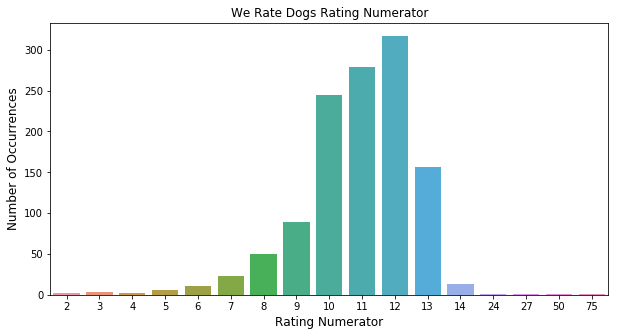

In [69]:
# bar plot of rating numerator
rating_count  = df_we_rate_dogs['rating_numerator'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(rating_count.index, rating_count.values)
plt.title('We Rate Dogs Rating Numerator')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Rating Numerator', fontsize=12)
plt.show()

The mean rating numerator is 11, while its median is also 11.

<a id='analyzing_ref'></a>
### References Data Analysis
Basic pie chart: https://matplotlib.org/3.2.1/gallery/pie_and_polar_charts/pie_features.html#sphx-glr-gallery-pie-and-polar-charts-pie-features-py<br>
Seaborn barplot and pandas value_counts: https://www.kaggle.com/tejainece/seaborn-barplot-and-pandas-value-counts <br>
